In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import astropy.units as u
import astropy.constants as c
import astropy.units as cu
from astropy.cosmology import Planck15 as cosmo
from colossus.cosmology import cosmology
from Corrfunc.theory import DDrppi, DD
from Corrfunc.utils import convert_rp_pi_counts_to_wp, convert_3d_counts_to_cf
sys.path.insert(0, '/work/08811/aew492/frontera/small-scale_cross-corrs')
from illustris_sim import TNGSim
import photxspec
import corrfuncs
import tools
from linear_theory import powerspec_to_wlin

### three methods

**single snapshot:**

Angular cross-correlation: directly compute the pair counts from Corrfunc
*(make sure the weights used to construct the photometric sample are consistent with those used in the multiple snapshot case)

**multiple snapshots:**

1. Compute projected auto-correlation for spectroscopic sample in each snapshot, direct pair counts from Corrfunc
2. Apply photometric weights $W_\mathrm{phot}$ given by Gaussian with width from redshift error $\sigma_z\rightarrow\mathrm{d}x$:

\begin{eqnarray}
w_x(\theta) &=& \int\mathrm{d}\chi W_\mathrm{phot}(\chi)W_i(\chi)\int_{-\infty}^\infty\mathrm{d}x_{||}\xi_x\left(\sqrt{x_{||}^2 + \chi^2\theta^2};z_i\right) \\
&\approx& \frac{1}{N_\mathrm{phot}}\frac{\mathrm{d}N_\mathrm{phot}}{\mathrm{d}\chi}(z=z_i)w_{p,x}(\chi\theta;z_i)
\end{eqnarray}

**linear theory:**

We need (1) photometric weights $W_\mathrm{phot}$, (2) bias of the spectroscopic sample, (3) linear matter power spectrum.

$$
w_{x,\mathrm{lin}}(\theta)\approx\frac{1}{N_\mathrm{phot}}\frac{\mathrm{d}N_\mathrm{phot}}{\mathrm{d}\chi}(z_i)b_i^2(z_i)\frac{1}{\chi^2(z_i)}\int_0^\infty\frac{\mathrm{d}\ell}{2\pi}\ell J_0(\ell\theta)\,P_\mathrm{lin}(k=\ell/\chi;z_i)
$$

If photometric weights are $W_\mathrm{phot}=1$, does this become the spectroscopic autocorrelation?

$$
w_{x,\mathrm{lin}}(\theta)\approx(1)\,b_i^2(z_i)\frac{1}{\chi^2(z_i)}\int_0^\infty\frac{\mathrm{d}\ell}{2\pi}\ell J_0(\ell\theta)\,P_\mathrm{lin}(k=\ell/\chi;z_i)
$$

### load TNG snapshot

In [4]:
# construct SPHEREx-like spectroscopic galaxy sample
redshift = 0.4

sigma_z = 0.03  # one of the 5 redshift error bins in SPHEREx

sim = TNGSim('TNG300-3', redshift=redshift)
chi = tools.redshift_to_comov(sim.redshift)  # comoving distance to the box center
    
# construct spectroscopic gals
gal_pos_spec = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]
gal_pos_spec -= sim.boxsize / 2

 number density for SPHEREx at z=0.4: 3.62e-03 (h/Mpc)^3 
target number of subhalos: 31186


### construct photometric sample (only used to compute pair counts for angular 2pcf)

In [6]:
# construct photometric sample
dx = tools.get_dx(sim.redshift, sigma_z)
gal_pos_phot = photxspec.construct_photometric_sample(gal_pos_spec, dx)

In [8]:
# divide the spectroscopic sample into slices along the LOS
nslices = 11
losbins = np.linspace(-sim.boxsize.value/2, sim.boxsize.value/2, nslices+1) << sim.boxsize.unit
slicewidth = (losbins[1]-losbins[0])
slice_centers = np.array([(losbins[i].value+losbins[i+1].value)/2 for i in range(nslices)]) << sim.boxsize.unit
slices_spec = [
    gal_pos_spec[(losbins[i] <= gal_pos_spec[:,2]) & (gal_pos_spec[:,2] < losbins[i+1])] \
    for i in range(nslices)
]

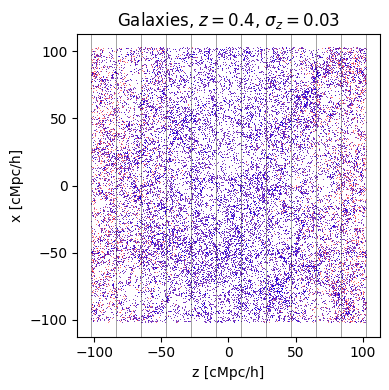

In [10]:
# plot both samples
fig, ax = plt.subplots(figsize=(7,4))
kwargs = dict(ls='None', marker=',', alpha=0.5)
ax.plot(gal_pos_spec[:,2].value, gal_pos_spec[:,0].value, c='r', **kwargs)
ax.plot(gal_pos_phot[:,2].value, gal_pos_phot[:,0].value, c='b', **kwargs)
for x in losbins:
    ax.axvline(x.value, ls='-', c='k', lw=0.5, alpha=0.5)
ax.set_aspect('equal')
ax.set_xlabel('z [cMpc/h]')
ax.set_ylabel('x [cMpc/h]')
ax.set_title(f'Galaxies, $z={sim.redshift}$, $\sigma_z={sigma_z}$')
fig.tight_layout()

### comoving distance $r\ \leftrightarrow$ angular separation $\theta$

In [5]:
# ! note redshift needs to be defined in the TNGSim earlier;
#    to use with mpl axis labels, we need a single input and dimensionless output
def theta_to_r_comov_(theta):  # theta in DEGREES
    return tools.theta_to_r_comov(theta, sim.redshift).value
def r_comov_to_theta_(r):
    return tools.r_comov_to_theta(r, sim.redshift).value